In [1]:
import numpy as np
import scipy
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False



import sys,os,pdb,copy,pickle
from importlib import reload
# import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
sys.path.append('/mnt/home/szheng/projects/place_variability/code')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp


import change_point_analysis as cpa
import change_point_plot as cpp

import place_field_analysis as pf

import switch_analysis_one_session as saos
reload(saos)

import process_central_arm as pca 
import change_point_analysis_central_arm_seperate as cpacas

import misc
reload(misc)
from misc import get_nth_key, get_nth_val

67 sessions!
67 sessions!


/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
import database
db = database.db

subdb = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)
subdb = subdb.query('ntrials>=20&n_neurons>=50')
to_exclude_sess = ['e16_3m2_211211']
subdb=subdb.loc[~subdb['sess_name'].isin(to_exclude_sess)]


import pf_recombine_central as pfrc
import fr_map_one_session as fmos
import switch_detection_one_session as sdos
import get_all_switch_add_metrics as gasam

import preprocess_one_session as prepos
import sw_and_int_one_sess as sios

In [4]:
figdir = '/mnt/home/szheng/ceph/place_variability/fig/paper/figure_cosw_birthdate'
figdir = misc.get_or_create_subdir(figdir)

/mnt/home/szheng/ceph/place_variability/fig/paper/figure_cosw_birthdate made!


In [16]:
fn = 'prepped_data_agg.p'
data_dir = '/mnt/home/szheng/ceph/place_variability/data/paper'
fn_full = os.path.join(data_dir,fn)
prepped_data_agg = pickle.load(open(fn_full,'rb'))

all_fields_recombined_all = prepped_data_agg['all_fields_recombined_all']
pf_params_recombined_all=  prepped_data_agg['pf_params_recombined_all']
fr_map_trial_df_all= prepped_data_agg['fr_map_trial_df_all']
occu_map_all = prepped_data_agg['occu_map_all']
fr_map_all = prepped_data_agg['fr_map_all']

pval_all = prepped_data_agg['pval_all']
X_pwc_all = prepped_data_agg['X_pwc_all']
X_raw_all = prepped_data_agg['X_raw_all']
changes_df_all = prepped_data_agg['changes_df_all']
var_res_all_test = prepped_data_agg['var_res_all']
# corr_all = prepped_data_agg['corr_all']
all_sw_d_all = prepped_data_agg['all_sw_d_all']
all_sw_with_metrics_d_all = prepped_data_agg['all_sw_with_metrics_d_all']
best_n_all_test = prepped_data_agg['best_n_all']
spk_beh_df_all = prepped_data_agg['spk_beh_df_all']

ntrials_per_tt=fr_map_trial_df_all.groupby(level=(0,1,2,3)).apply(lambda x:x.dropna(axis=1,how='all').shape[1])
ntrials_mask = ntrials_per_tt.groupby(level=(0,1,2)).apply(lambda x:(x>=7).all()) 


In [6]:
# import switch_detection_sweep_penalty_one_session as sdspos
# import get_all_switch_add_metrics_pen as gasamp
# reload(gasamp)
# pen=0.5#0.3#0.3#0.5

# best_n_all = {}
# X_pwc_all={}
# X_raw_all={}
# changes_df_all={}
# var_res_all={}
# corr_all = {}
# p_corr_all = {}
# all_sw_d_all={}
# all_sw_with_metrics_d_all = {}

# for ind,row in subdb.iterrows():
#     data_dir_full = row['data_dir_full']
#     ani = ind[0]
#     sess = row['sess_name']
#     sw_res_pelt = sdspos.main(data_dir_full,force_reload=False,dosave=False,load_only=True)
    
#     sw_info_res_pelt=gasamp.main(data_dir_full,force_reload=False,load_only=True,dosave=False)
#     if sw_info_res_pelt is None:
#         sw_info_res_pelt=gasamp.main(data_dir_full,force_reload=True,load_only=False)
#     all_sw_d = sw_info_res_pelt['all_sw_d_pen'][pen]
#     all_sw_d_all[ani,sess] = all_sw_d
#     all_sw_with_metrics_d = sw_info_res_pelt['all_sw_with_metrics_d_pen'][pen]
#     all_sw_with_metrics_d_all[ani,sess] = all_sw_with_metrics_d
    
#     all_sw_res= gasamp.main(data_dir_full,force_reload=False,dosave=False,load_only=True)
#     sw_res_pelt = sw_res_pelt[pen]
    
#     best_n_all[ani,sess]=sw_res_pelt['best_n']
#     X_pwc_all[ani,sess]=sw_res_pelt['X_pwc']
#     X_raw_all[ani,sess]=sw_res_pelt['X_raw']
#     changes_df_all[ani,sess]=sw_res_pelt['changes_df']
#     var_res_all[ani,sess]=sw_res_pelt['var_res']
#     corr_all[ani,sess]=sw_res_pelt['corr']
#     p_corr_all[ani,sess]=sw_res_pelt['p_corr']
    
# best_n_all = pd.concat(best_n_all,axis=0)
# X_pwc_all = pd.concat(X_pwc_all,axis=0)
# X_raw_all = pd.concat(X_raw_all,axis=0)
# changes_df_all = pd.concat(changes_df_all,axis=0)
# var_res_all = pd.concat(var_res_all,axis=0)
# corr_all = pd.concat(corr_all,axis=0)
# p_corr_all = pd.concat(p_corr_all,axis=0)

# all_sw_d_all=pd.concat(all_sw_d_all,axis=0)
# all_sw_with_metrics_d_all = pd.concat(all_sw_with_metrics_d_all,axis=0)


/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/penalty_sw_res_afterheadscan_fr_peak.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/switch_analysis/all_sw_info_pen.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/switch_analysis/all_sw_info_pen.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/penalty_sw_res_afterheadscan_fr_peak.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/switch_analysis/all_sw_info_pen.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/switch_analysis/all_sw_info_pen.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220118/py_data/penalty_sw_res_afterheadscan_fr_peak.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220118/py_data/switch_analysis/all_sw_info_pe

/mnt/home/szheng/ceph/ad/roman_data/e15/e15_9f1/e15_9f1_200729/py_data/penalty_sw_res_afterheadscan_fr_peak.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_9f1/e15_9f1_200729/py_data/switch_analysis/all_sw_info_pen.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_9f1/e15_9f1_200729/py_data/switch_analysis/all_sw_info_pen.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m2/e14_2m2_201019/py_data/penalty_sw_res_afterheadscan_fr_peak.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m2/e14_2m2_201019/py_data/switch_analysis/all_sw_info_pen.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m2/e14_2m2_201019/py_data/switch_analysis/all_sw_info_pen.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210319/py_data/penalty_sw_res_afterheadscan_fr_peak.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210319/py_data/switch_analysis/all_sw_info_pen.p exists; 

In [7]:
# testing the combined function
import co_sw_and_ripple_cofiring_one_sess as csarcos
reload(csarcos)

<module 'co_sw_and_ripple_cofiring_one_sess' from '/mnt/home/szheng/projects/place_variability/code/co_sw_and_ripple_cofiring_one_sess.py'>

In [8]:
import pairwise_analysis as pwa
reload(pwa)
import switch_metrics as sm
reload(sm)
import test_co_switch as tcs
reload(tcs)
import shuffle_changes_df_one_session as scdos

In [70]:
row = subdb.iloc[3]
task_index=0
data_dir_full=ddf = row['data_dir_full']
ani=row['animal_name.1']
sess = row['sess_name']
# ani,sess,task_index = 'e13_26m1','e13_26m1_210913',0
changes_df_one = changes_df_all.loc[ani,sess,task_index]
all_sw_d_one = all_sw_d_all.loc[ani,sess,task_index]
pf_params_recombined_one=pf_params_recombined_all.loc[ani,sess]
# changes_df_one = changes_df_all.loc[ani,sess]
spk_beh_df = spk_beh_df_all.loc[ani,sess]

/tmp/ipykernel_869000/2502315180.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  changes_df_one = changes_df_all.loc[ani,sess,task_index]
/tmp/ipykernel_869000/2502315180.py:8: PerformanceWarning: indexing past lexsort depth may impact performance.
  all_sw_d_one = all_sw_d_all.loc[ani,sess,task_index]
/tmp/ipykernel_869000/2502315180.py:9: PerformanceWarning: indexing past lexsort depth may impact performance.
  pf_params_recombined_one=pf_params_recombined_all.loc[ani,sess]
/tmp/ipykernel_869000/2502315180.py:11: PerformanceWarning: indexing past lexsort depth may impact performance.
  spk_beh_df = spk_beh_df_all.loc[ani,sess]


In [71]:
reload(sdos)
reload(tcs)
reload(scdos)
shuffle_all_sw_one=scdos.main(ddf,test_mode=False,dosave=False,force_reload=False,load_only=True)

/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220119/py_data/shuffle_all_sw_afterheadscan.p exists; loading---


In [72]:
%%time
sw_sim_allonoff_shuffle = []
diff_key = 'trial_index'#'time'#
win_l = [0,1]#[1,30]#[0,1,2]
sw_sim_allonoff,time_diff = pwa.get_sw_sim(all_sw_d_one,diff_key=diff_key,win_l=win_l,decay_rate_l=[])

for ii,allsw in enumerate(shuffle_all_sw_one[:200]):
    ss, td=pwa.get_sw_sim(allsw.loc[task_index],diff_key=diff_key,win_l=win_l,decay_rate_l=[])
#     sw_sim_allonoff_shuffle[ii]=sw_sim_allonoff
    sw_sim_allonoff_shuffle.append(ss)


CPU times: user 5.66 s, sys: 18.9 ms, total: 5.68 s
Wall time: 5.68 s


In [73]:
# generic preoprocess
mat_to_return=prep.load_stuff(data_dir_full)
# sessionPulses=mat_to_return['sessionPulses']
# filtered = mat_to_return['filtered']
# behavior=mat_to_return['behavior']
ripples = mat_to_return['ripples']
cell_metrics=mat_to_return['cell_metrics']
mergepoints = mat_to_return['mergepoints']

res_all_epochs_d, ripple_time_ints_epochs_d = prep.get_spike_count_rate_participation_in_ripple_all(cell_metrics,
                                                                                                    ripples,
                                                                                                    mergepoints,
                                                                                                   )


In [74]:
%%time
import pairwise_analysis as pwa
reload(pwa)
ripple_sim_d = pwa.get_all_ripple_pairwise_sim(cell_metrics,ripples,mergepoints)

CPU times: user 20.7 s, sys: 105 ms, total: 20.8 s
Wall time: 20.8 s


In [31]:
mergepoints['timestamps']

array([[    0.        ,  5616.60796667],
       [ 5616.608     ,  7716.63996667],
       [ 7716.64      , 13105.59996667],
       [13105.6       , 15049.02396667],
       [15049.024     , 19118.94396667],
       [19118.944     , 21627.77596667],
       [21627.776     , 27902.77596667],
       [27902.776     , 29653.11196667]])

<Axes: >

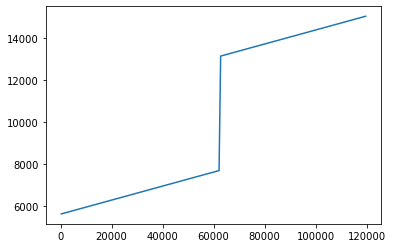

In [34]:
spk_beh_df['time'].plot()

/tmp/ipykernel_869000/1875395712.py:11: PerformanceWarning: indexing past lexsort depth may impact performance.
  label_sim_one = ripple_sim_d.loc['ripple_only',rip_sim_key,epoch]


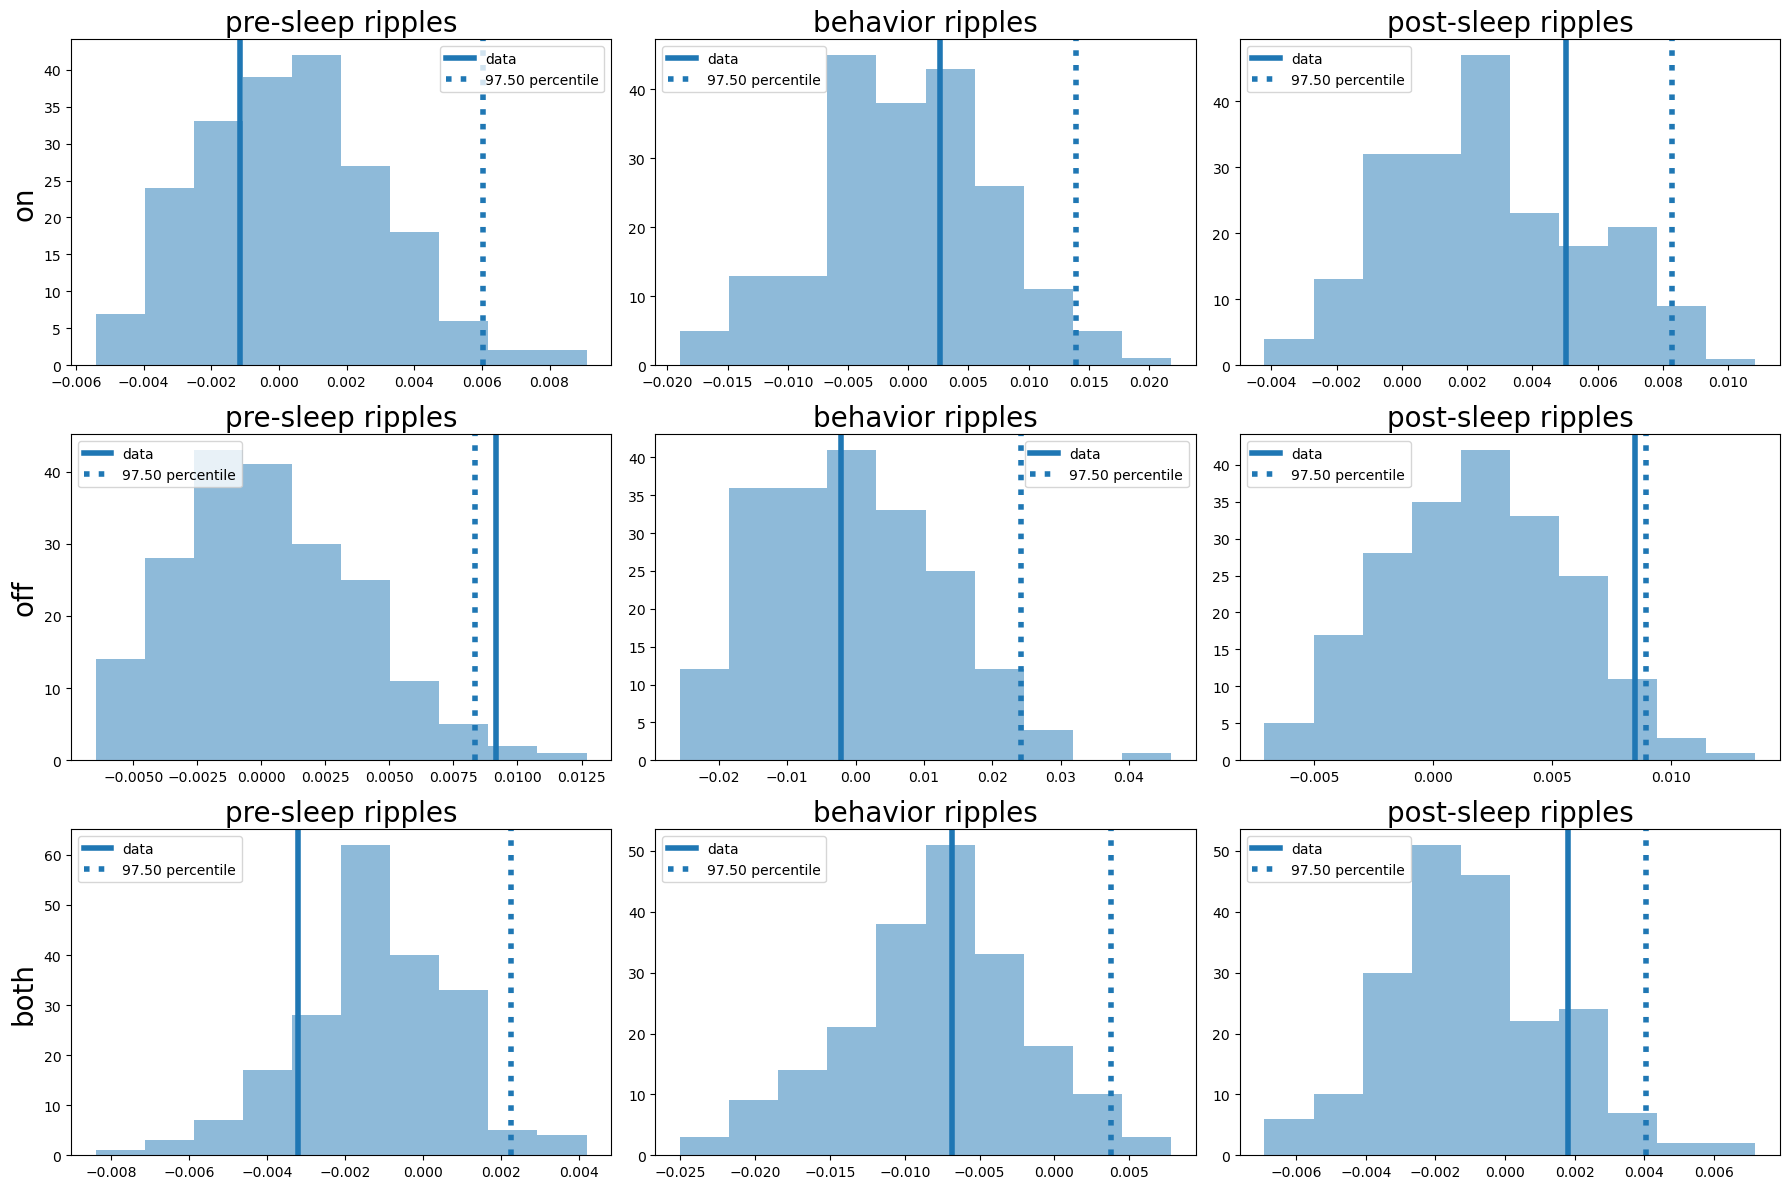

In [76]:

onoff_str_d = {1:'on',-1:'off','both':'both'}
sw_key='within_1'#'within_30'#'within_1'#'within_30'#'within_0'
rip_sim_key = 'count_in_interval'#'participation_in_interval'

fig,axs = plt.subplots(3,3,figsize=(6*3,4*3))
for ii,onoff in enumerate([1,-1,'both']):
    onoff_str=onoff_str_d[onoff]
    epoch_name = ['pre-sleep ripples','behavior ripples','post-sleep ripples']
    for jj,epoch in enumerate([0,1,2]):
#     for jj,epoch in enumerate([3,4,5]):
        label_sim_one = ripple_sim_d.loc['ripple_only',rip_sim_key,epoch]
        co_sw_sim_one = sw_sim_allonoff.loc[onoff,sw_key]
    
        ax=axs[ii,jj]
        diff_data,diff_data_sh_l,pval,fig,ax=pwa.shuffle_test_label_switch_diff_plot(label_sim_one,co_sw_sim_one,sw_sim_allonoff_shuffle,onoff=onoff,sw_key=sw_key,
                                            fig=fig,ax=ax,doplot=True
                                           )
        title = epoch_name[jj]
        ax.set_title(title)
        if jj==0:
            ax.set_ylabel(onoff_str)
plt.tight_layout()


['Pyramidal Cell',
 'Wide Interneuron',
 'Narrow Interneuron',
 'Narrow Interneuron',
 'Narrow Interneuron',
 'Narrow Interneuron',
 'Narrow Interneuron',
 'Narrow Interneuron',
 'Narrow Interneuron',
 'Narrow Interneuron',
 'Narrow Interneuron',
 'Narrow Interneuron',
 'Narrow Interneuron',
 'Narrow Interneuron',
 'Narrow Interneuron',
 'Narrow Interneuron',
 'Narrow Interneuron',
 'Narrow Interneuron',
 'Narrow Interneuron',
 'Narrow Interneuron',
 'Narrow Interneuron',
 'Narrow Interneuron',
 'Narrow Interneuron',
 'Narrow Interneuron',
 'Narrow Interneuron',
 'Narrow Interneuron',
 'Narrow Interneuron',
 'Narrow Interneuron',
 'Narrow Interneuron',
 'Narrow Interneuron',
 'Narrow Interneuron',
 'Narrow Interneuron',
 'Narrow Interneuron',
 'Narrow Interneuron',
 'Narrow Interneuron',
 'Narrow Interneuron',
 'Narrow Interneuron',
 'Wide Interneuron',
 'Pyramidal Cell',
 'Pyramidal Cell',
 'Narrow Interneuron',
 'Pyramidal Cell',
 'Wide Interneuron',
 'Narrow Interneuron',
 'Wide Int

In [77]:
same_birth =(cell_metrics.optoTag.p_salt < 0.001) & (cell_metrics.optoTag.h_reliable)
same_birth_mat = same_birth[:,None].dot(same_birth[None,:])
cell_cols_d_all = np.arange(len(cell_metrics['putativeCellType']))+1
# same_birth_df = pd.DataFrame(same_birth_mat.astype(int),columns=cell_cols_d['all'],index=cell_cols_d['all'])
same_birth_df = pd.DataFrame(same_birth_mat.astype(int),columns=cell_cols_d_all,index=cell_cols_d_all)


In [45]:
def label_difference_grouped_by_coswitch(label_sim_one,co_sw_sim_one):
    label_sim_one = label_sim_one.dropna(axis=0,how='all').dropna(axis=1,how='all')
    co_sw_sim_one = co_sw_sim_one.dropna(axis=0,how='all').dropna(axis=1,how='all')
    c1 = label_sim_one.index
    c2 = co_sw_sim_one.index
    common_ind = c1.intersection(c2)
    label=label_sim_one.loc[common_ind,common_ind].values
    cosw=co_sw_sim_one.loc[common_ind,common_ind].values
    label_flatten=np.ravel(label[np.triu_indices_from(label,1)])
    cosw_flatten=np.ravel(cosw[np.triu_indices_from(cosw,1)])
    diff = np.mean(label_flatten[cosw_flatten==1]) - np.mean(label_flatten[cosw_flatten==0])
#     diff = scipy.stats.pearsonr(label_flatten,cosw_flatten)[0]
    return diff, label_flatten, cosw_flatten
    
    
    
# shuffle
def shuffle_test_label_switch_diff_plot(label_sim_one,co_sw_sim_one,sw_sim_allonoff_shuffle,onoff=1,sw_key='within_1',
                                        fig=None,ax=None,doplot=False
                                       ):
    diff_data,label_flatten,cosw_flatten = label_difference_grouped_by_coswitch(label_sim_one,co_sw_sim_one)
    diff_data_sh_l = []
    for ss in sw_sim_allonoff_shuffle:
        cosw_shuffle_one=ss.loc[onoff,sw_key]
        diff_data_sh,label_flatten,cosw_flatten_sh=label_difference_grouped_by_coswitch(label_sim_one,cosw_shuffle_one)
        diff_data_sh_l.append(diff_data_sh)
    diff_data_sh_l = np.array(diff_data_sh_l)
    pval = 1-(diff_data > diff_data_sh_l).mean()
    to_return = [diff_data,diff_data_sh_l, pval]
    if doplot:
        fig,ax=ph.plot_shuffle_data_dist_with_thresh(diff_data_sh_l,diff_data,fig=fig,ax=ax)
        to_return.extend([fig,ax])
    return tuple(to_return)
        


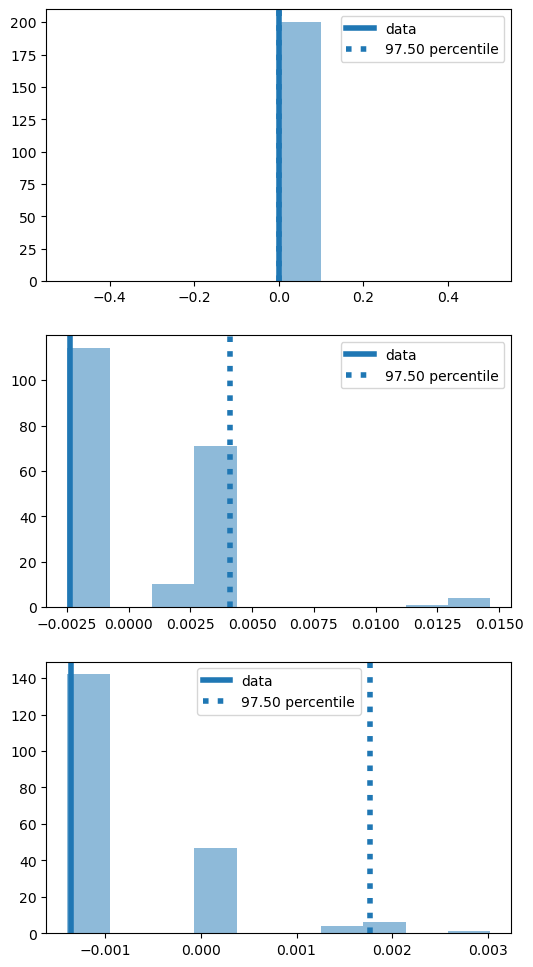

In [78]:
label_sim_one = same_birth_df
fig,axs = plt.subplots(3,1,figsize=(6*1,4*3))
for ii,onoff in enumerate([1,-1,'both']):
    ax=axs[ii]
    co_sw_sim_one = sw_sim_allonoff.loc[onoff,sw_key]
    diff_data,diff_data_sh_l,pval,fig,ax=shuffle_test_label_switch_diff_plot(label_sim_one,co_sw_sim_one,sw_sim_allonoff_shuffle,onoff=onoff,sw_key=sw_key,
                                    fig=fig,ax=ax,doplot=True
                                   )

In [20]:
shuffle_all_sw_one[0]

trialtype  uid  field_index          time  speed_gauss  field_pos  \
0 0        both   65            1   5759.707233    20.933083       24.0   
  1         0.0   65            0   5808.786350    16.310098        7.0   
  2         0.0   91            1   5812.287233    14.344839       38.0   
  3         0.0  111            0   5817.042612     4.181895       52.0   
  4         0.0  123            0   5810.761850    12.159204       32.0   
...         ...  ...          ...           ...          ...        ...   
1 267       1.0  311            1  13962.508000    16.037261       25.0   
  268       1.0   95            0  13980.045833     4.530620       43.0   
  269       1.0  179            0  13983.963500     8.475981       31.0   
  270       1.0  267            0  13986.264133    14.151928        5.0   
  271       1.0  272            0  13985.914000    14.420184       10.0   

       trial_index  switch  index_within  switch_trial  switch_trial_frac  \
0 0              3    -1.0             1           3.0           0.120000   
  1              4     1.0             2           2.0           0.133333   
  2              4     1.0             2           2.0           0.133333   
  3              4     1.0             2           2.0           0.133333   
  4              4     1.0             2           2.0           0.133333   
...            ...     ...           ...           ...                ...   
1 267           32    -1.0            16          16.0           0.457143   
  268           33     1.0            16          16.0           0.457143   
  269           33    -1.0            16          16.0           0.457143   
  270           33    -1.0            16          16.0           0.457143   
  271           33    -1.0            16          16.0           0.457143   

       pre_ntrials_in_segment  post_ntrials_in_segment  
0 0                         3                       22  
  1                         2                       13  
  2                         2                       13  
  3                         2                       13  
  4                         2                        2  
...                       ...                      ...  
1 267                      16                       19  
  268                      16                       19  
  269                       3                       19  
  270                       3                       19  
  271                      16                       19  

[412 rows x 13 columns]

In [14]:
all_sw_d_one

,trialtype,uid,field_index,time,speed_gauss,field_pos,trial_index,switch,index_within,switch_trial,switch_trial_frac,pre_ntrials_in_segment,post_ntrials_in_segment
0,0.0,285,1,13188.778060,34.401687,29.272905,2,1.0,1,1.0,0.030303,1,32
1,0.0,85,1,13205.485458,20.211797,42.103056,3,-1.0,1,1.0,0.030303,1,32
2,0.0,119,0,13205.162028,19.041458,44.874656,3,-1.0,1,1.0,0.030303,1,32
3,0.0,142,0,13205.357978,20.080934,43.195559,3,-1.0,1,1.0,0.030303,1,32
4,0.0,183,1,13207.547219,34.901683,24.015622,3,-1.0,1,1.0,0.030303,1,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...
218,0.0,323,0,13936.830568,13.576668,10.925208,31,1.0,15,15.0,0.454545,15,18
219,1.0,282,1,13929.900214,9.260949,44.497181,31,1.0,15,15.0,0.428571,15,20
220,1.0,72,1,13963.524465,21.798651,20.594380,32,1.0,16,16.0,0.457143,16,19
221,1.0,267,0,13957.540811,6.673703,7.418506,32,-1.0,16,16.0,0.457143,1,19
